In [1]:
# this prediction model tires to model the current year feature values with the next year's class value
# with out any prediction for the feature values
# smotenc added 

In [134]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from collections import Counter

warnings.filterwarnings("ignore")
randomseed = 7

1.  Read dataset
===

In [170]:
x_original = pd.read_csv("../../../XLable_onlyDiabeticRemoved.txt")

conditions = [
    (x_original.L100800 < 100),
    (x_original.L100800 >= 100) & (x_original.L100800 < 126),
    (x_original.L100800 >= 126),
]
choices = [0, 1, 2]
x_original["CLASS"] = np.select(conditions, choices, default=0)
x_original=x_original [['Unnamed: 0','L100800','L104600','L103000','S000300','L101700','L100700','FIELD_33',
                       'FIELD_38','FIELD_40','FIELD_31','SEX','AGE',#'CLASS',
                       'FIELD_16','FIELD_23','FIELD_15','FIELD_22','FIELD_17','FIELD_24'
                       ]]

In [171]:
y_original = pd.read_csv("../../../TargetLable_onlyDiabeticRemoved.txt")

conditions = [
    (y_original.L100800 < 100),
    (y_original.L100800 >= 100) & (y_original.L100800 < 126),
    (y_original.L100800 >= 126),
]

choices = [0, 1, 2]
y_original["CLASS"] = np.select(conditions, choices, default=0)

y_original=y_original[['Unnamed: 0','CLASS' ]]

In [172]:
data = pd.merge(
    x_original, y_original, how="inner", left_on="Unnamed: 0", right_on="Unnamed: 0"
)

In [173]:
# filter the data set
data = data[data.FIELD_16 != 1]  # exclude people who are diagnosed for (diabetes)
data = data[data.FIELD_23 != 1]  # exclude people who are on medication for diabetes

data = data[
    data.FIELD_15 != 1
]  # exclude people who are diagnosed for (high blood pressure)
data = data[
    data.FIELD_22 != 1
]  # exclude people who are on medication for high blood pressure

data = data[data.FIELD_17 != 1]  # exclude people who are diagnosed for hyperlipidemia
data = data[
    data.FIELD_24 != 1
]  # exclude people who are on medication for hyperlipidemia


print(data.shape)

(169024, 20)


In [174]:
data=data.dropna()
print(data.shape)
data=data[['L100800','L104600', 'L103000', 'S000300', 'L101700', 'L100700',
       'FIELD_33', 'FIELD_38', 'FIELD_40', 'FIELD_31', 'SEX', 'AGE','CLASS']]
data.head()

(56438, 20)


,L100800,L104600,L103000,S000300,L101700,L100700,FIELD_33,FIELD_38,FIELD_40,FIELD_31,SEX,AGE,CLASS
2,78.0,5.28,41.0,20.2,15.0,3.8,1.0,2.0,1.0,0.0,1.0,46.0,0
5,90.0,5.74,50.0,25.5,12.0,3.4,1.0,0.0,1.0,0.0,1.0,52.0,0
10,86.0,5.83,45.0,21.2,17.0,3.9,1.0,0.0,1.0,1.0,1.0,37.0,0
11,86.0,4.73,54.0,22.0,30.0,4.2,1.0,2.0,3.0,0.0,1.0,39.0,0
20,87.0,5.60,340.0,24.6,26.0,4.7,1.0,0.0,2.0,0.0,1.0,59.0,0


In [175]:
data.groupby(by='CLASS').size()

CLASS
0    38091
1    17305
2     1042
dtype: int64

2. Downsample the majority class and upsample the minority
===

In [176]:
diabetic = data[data.CLASS == 2]
prediabetic = data[data.CLASS == 1]
normal = data[data.CLASS == 0]

print(diabetic.shape[0], prediabetic.shape[0], normal.shape[0])

1042 17305 38091


In [177]:
diabetic_test = diabetic.sample(200, random_state=randomseed)
prediabetic_test = prediabetic.sample(200, random_state=randomseed)
normal_test = normal.sample(200, random_state=randomseed)
test = pd.concat([diabetic_test, prediabetic_test, normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index)
# .sample(
#     10 * diabetic_train.shape[0], random_state=randomseed
# )
normal_train = normal.drop(normal_test.index).sample(
    prediabetic_train.shape[0]
#     10 * diabetic_train.shape[0], random_state=randomseed
)
train = pd.concat([diabetic_train, diabetic_train, prediabetic_train, normal_train])

In [178]:

xtrain = train.iloc[:, :-1]
ytrain = train.iloc[:, -1]
xtest = test.iloc[:, :-1]
ytest = test.iloc[:, -1]

In [179]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
xtrain=scaler.fit_transform(xtrain)
xtest=scaler.transform(xtest)


In [180]:
from imblearn.over_sampling import SMOTE,SMOTENC  # doctest: +NORMALIZE_WHITESPACE
randomseed=42

sm = SMOTENC(random_state=randomseed,categorical_features=[6,7,8,9,10],sampling_strategy='minority')
X_res, y_res = sm.fit_resample(xtrain, ytrain)

print("Resampled dataset shape %s" % Counter(y_res))
print(
    y_res[y_res == 0].shape[0], y_res[y_res == 1].shape[0], y_res[y_res == 2].shape[0]
)
print(X_res.shape, y_res.shape)

xtrain = X_res
ytrain = y_res


Resampled dataset shape Counter({2: 17105, 1: 17105, 0: 17105})
17105 17105 17105
(51315, 12) (51315,)


In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

parameters = {'max_features':('auto', 'sqrt','log2'), 'n_estimators':[10,50,100,150,200,300,700]}
rf_clf = RandomForestClassifier()
rf_clf = GridSearchCV(rf_clf, parameters)
rf_clf.fit(xtrain, ytrain)

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
           

In [17]:
rf_clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [181]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    random_state=randomseed,
    n_estimators=100,
    max_depth=12,
    min_samples_split=2,
    min_samples_leaf=10,
    max_features="auto",
)

# rf=rf_clf.best_estimator_
# rf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=None, max_features='log2', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=1, min_samples_split=2,
#                        min_weight_fraction_leaf=0.0, n_estimators=700,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)


rf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=12, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [19]:
from sklearn import model_selection
scores = model_selection.cross_val_score(rf, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'RandomForestClassifier',scores))

Accuracy: 0.78 (+/- 0.04) [RandomForestClassifier] 
 [[0.66822521 0.76914085 0.7773232  0.79290863 0.80264952 0.81033138
 0.80545809 0.79610136 0.80350877 0.78323587]]


0.7283333333333334


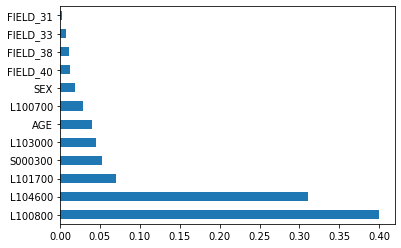

Index(['L100800', 'L104600', 'L101700', 'S000300', 'L103000', 'AGE', 'L100700',
       'SEX', 'FIELD_40', 'FIELD_38', 'FIELD_33', 'FIELD_31'],
      dtype='object')


In [182]:
ypred = rf.predict(xtest)

score = rf.score(xtest, ytest)
print(score)

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:, :-1].columns)
feat_importances.nlargest(16).plot(kind="barh")
plt.show()

print(feat_importances.nlargest(16).index)

In [183]:
print("Accuracy on training set: {:.3f}".format(rf.score(xtrain, ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest, ytest)))

confmatrx = pd.DataFrame(m.confusion_matrix(ytest, ypred))
confmatrx.head()

Accuracy on training set: 0.814
Accuracy on test set: 0.728


,0,1,2
0,145,53,2
1,50,133,17
2,3,38,159


In [184]:
from sklearn.metrics import classification_report

print(classification_report(ytest, ypred))

              precision    recall  f1-score   support

           0       0.73      0.72      0.73       200
           1       0.59      0.67      0.63       200
           2       0.89      0.80      0.84       200

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.73       600
weighted avg       0.74      0.73      0.73       600



xgboost
=====

In [114]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

parameters = {'max_depth':[3,5,7,9],
              'n_estimators':[10,50,100,200,700]}
xgb_clf = xgb.XGBClassifier()
xgb_clf = GridSearchCV(xgb_clf, parameters)
xgb_clf.fit(xtrain, ytrain)

KeyboardInterrupt: 

In [ ]:
xgb_clf.best_estimator_

In [122]:
import xgboost as xgb
from sklearn import metrics as m

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=randomseed)
# objective="multi:softmax"
# xgb_model=xgb_clf.best_estimator_

In [123]:


xgb_model.fit(xtrain, ytrain)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
from sklearn import model_selection
scores = model_selection.cross_val_score(xgb_model, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'xgb_model',scores))

Accuracy: 0.72 (+/- 0.04) [xgb_model] 
 [[0.60685759 0.69530489 0.7194623  0.74576271 0.73991818 0.73138402
 0.71598441 0.71929825 0.74444444 0.73547758]]


In [124]:

y_pred = xgb_model.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.7333333333333333


,0,1,2
0,158,42,0
1,52,125,23
2,1,42,157


In [125]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       200
           1       0.60      0.62      0.61       200
           2       0.87      0.79      0.83       200

    accuracy                           0.73       600
   macro avg       0.74      0.73      0.74       600
weighted avg       0.74      0.73      0.74       600



SVM
====

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [38]:


parameters = {'kernel':('linear', 'rbf'), 'C':[1,5,10,15,20,25,30,70]}
SVC_clf = SVC()
SVC_clf2 = GridSearchCV(SVC_clf, parameters)
SVC_clf2.fit(xtrain, ytrain)


# sorted(SVC_clf2.cv_results_.keys())

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1, 5, 10, 15, 20, 25, 30, 70],
                         'kernel': ('linear', 'rbf')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [39]:
SVC_clf2.best_estimator_

SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [127]:

# SVC_clf = SVC_clf2.best_estimator_
SVC_clf=SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
SVC_clf.fit(xtrain, ytrain)

SVC(C=70, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
from sklearn import model_selection
scores = model_selection.cross_val_score(SVC_clf, xtrain, ytrain, 
                                          cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s] \n [%s]" 
      % (scores.mean(), scores.std(), 'SVC_clf',scores))

In [128]:
y_pred = SVC_clf.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.7483333333333333


,0,1,2
0,160,39,1
1,52,125,23
2,2,34,164


Stacking Classifier
========


In [129]:
from sklearn import model_selection
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [130]:

lr = LogisticRegression()
tempreg=RandomForestClassifier(n_estimators=500, random_state=42)
tempreg2=RandomForestClassifier()
tempsvC= SVC()

estimators = [
    rf,
    xgb_model,
    SVC_clf
]
stackingc = StackingClassifier(
    classifiers=estimators,
    meta_classifier=tempreg2
)

In [132]:
scores = model_selection.cross_val_score(stackingc, xtrain, ytrain, 
                                          cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
      % (scores.mean(), scores.std(), 'stacking classifier'))

NameError: name 'label' is not defined

Accuracy: 0.74 (+/- 0.04) [stacking classifier]


In [28]:
print('3-fold cross validation:\n')

for clf, label in zip([rf,
    xgb_model,
    SVC_clf,reg], 
                      ['rf',
    'xgb_model',
    'SVC_clf',
                       'StackingClassifier']):

    scores = model_selection.cross_val_score(clf, xtrain, ytrain, 
                                              cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

3-fold cross validation:

Accuracy: 0.77 (+/- 0.04) [rf]
Accuracy: 0.72 (+/- 0.04) [xgb_model]
Accuracy: 0.72 (+/- 0.03) [SVC_clf]
Accuracy: 0.77 (+/- 0.04) [StackingClassifier]


In [ ]:
scores

In [58]:
reg.fit(xtrain,ytrain)

StackingClassifier(average_probas=False,
                   classifiers=[RandomForestClassifier(bootstrap=True,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=12,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=10,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       n_estimators=100,
                                                

In [59]:
y_pred = reg.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.73


,0,1,2
0,151,49,0
1,48,139,13
2,3,49,148


In [60]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75       200
           1       0.59      0.69      0.64       200
           2       0.92      0.74      0.82       200

    accuracy                           0.73       600
   macro avg       0.75      0.73      0.74       600
weighted avg       0.75      0.73      0.74       600



In [82]:

from sklearn.pipeline import make_pipeline
from mlxtend.feature_selection import ColumnSelector
from mlxtend.classifier import StackingCVClassifier

pipe1 = make_pipeline(rf)
pipe11 = make_pipeline( xgb_model)
pipe12 = make_pipeline( SVC_clf)
pipe13 = make_pipeline( LogisticRegression())

pipe2 = make_pipeline(ColumnSelector(cols=(0,1,2,9,10)), rf )
pipe21 = make_pipeline(ColumnSelector(cols=(0,1,2,9,10)), xgb_model )
pipe22 = make_pipeline(ColumnSelector(cols=(0,1,2,9,10)), SVC_clf )
pipe22 = make_pipeline(ColumnSelector(cols=(0,1,2,9,10)), LogisticRegression() )



sclf1 = StackingCVClassifier(classifiers=[    pipe1,    pipe11,    pipe12 ],
                           meta_classifier=LogisticRegression(),random_state=42)

sclf2 = StackingCVClassifier(classifiers=[    pipe2,    pipe21,    pipe22],
                           meta_classifier=LogisticRegression(),random_state=42)

sclf = StackingCVClassifier(classifiers=[
   sclf1,sclf2
], 
                            meta_classifier=LogisticRegression(),
                            random_state=42)




StackingCVClassifier(classifiers=[StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                             steps=[('randomforestclassifier',
                                                                                     RandomForestClassifier(bootstrap=True,
                                                                                                            class_weight=None,
                                                                                                            criterion='gini',
                                                                                                            max_depth=12,
                                                                                                            max_features='auto',
                                                                                                            max_leaf_nodes=None,
                                          

In [86]:

sclf.fit(xtrain,ytrain)

StackingCVClassifier(classifiers=[StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                             steps=[('randomforestclassifier',
                                                                                     RandomForestClassifier(bootstrap=True,
                                                                                                            class_weight=None,
                                                                                                            criterion='gini',
                                                                                                            max_depth=12,
                                                                                                            max_features='auto',
                                                                                                            max_leaf_nodes=None,
                                          

In [87]:
y_pred = sclf1.predict((xtest))

print("accuracy \t", m.accuracy_score(ytest, y_pred))
confmatrx = pd.DataFrame(m.confusion_matrix(ytest, y_pred))
confmatrx.head()

accuracy 	 0.7283333333333334


,0,1,2
0,153,47,0
1,51,136,13
2,3,49,148


In [90]:

from sklearn.model_selection import cross_val_score
scores = cross_val_score(sclf,
                         xtrain,ytrain,
                         cv=5,
                         scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
# multi-class classification with Keras
import pandas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras.utils import np_utils

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
 
# create model
model = Sequential()
model.add(Dense(64, input_dim=11, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(16, kernel_initializer='normal', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(3, kernel_initializer='normal', activation='linear'))


# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# estimator = KerasClassifier(build_fn=model, epochs=200, batch_size=5, verbose=0)
# kfold = KFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, xtrain, ytrain, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
history=model.fit(xtrain, np_utils.to_categorical( ytrain.to_numpy()), 
                  epochs=100, batch_size=10,validation_split=.2)

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# =====================================

tempdata=data5

diabetic = tempdata[tempdata.CLASS == 2]
prediabetic = tempdata[tempdata.CLASS == 1].sample(diabetic.shape[0],random_state=0)
normal = tempdata[tempdata.CLASS == 0].sample(diabetic.shape[0],random_state=0)

tempdata5=pd.concat([diabetic,prediabetic,normal])
tempdata5.iloc[:, 3:-2]=scaler.transform(tempdata5.iloc[:, 3:-2])

pred5 = rf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
#xgboost test

In [ ]:
tempdata5Rcolumns=tempdata5.iloc[:, 3:-2]
tempdata5Rcolumns.columns=['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10']
pred5 = xgb_model.predict((tempdata5Rcolumns))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))


In [ ]:
#SVC

In [ ]:
pred5 = SVC_clf.predict((tempdata5.iloc[:, 3:-2]))
print(m.accuracy_score(tempdata5.iloc[:, -1], pred5))

confmatrx = pd.DataFrame(m.confusion_matrix(tempdata5.iloc[:, -1], pred5))
confmatrx

In [ ]:
print(classification_report(tempdata5.iloc[:, -1], pred5))

In [ ]:
# ========================================================

In [ ]:
# import pickle

# with open('_DiabeticClassifierModelForNextYear_rf_model', 'wb') as f:
#     pickle.dump(rf, f)

In [ ]:
# with open('_DiabeticClassifierModelForNextYear_scaler', 'wb') as f:
#     pickle.dump(scaler, f)